In [195]:
# imports
import os
import json
import argparse
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from scipy.optimize import linear_sum_assignment

In [ ]:
# Paths/metadata (resolve relative to repo root)
FEATURES_DIR = '../data/features/genres_original'
MODEL_PATH = '../src/preprocess/best_model.keras'  # can change to different model to test
META_PATH = f'{FEATURES_DIR}/metadata.json'

# load metadata
with open(META_PATH, "r") as f:
    metadata = json.load(f)

model = load_model(MODEL_PATH)
num_outputs = int(model.output_shape[-1])

# Only getting 6 genres
classes_to_keep = sorted({m['genre'] for m in metadata})[:num_outputs]
print('genres:', classes_to_keep)

# labels for plotting later (blues: 0, classical: 1...)
label_map = {g: i for i, g in enumerate(classes_to_keep)}
print('label_map:', label_map)
num_classes = len(classes_to_keep)


genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz']
label_map: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5}


In [197]:
# build file list for relative paths to the features files and labels for NumPy array
file_paths, labels = [], []
for m in metadata:
    if m['genre'] not in classes_to_keep:
        continue
    genre = m['genre']
    npz_name = m['filename'].replace('.wav', '.npz')
    p = os.path.join(FEATURES_DIR, genre, npz_name)
    if os.path.exists(p):
        file_paths.append(p)
        labels.append(label_map[genre])
labels = np.array(labels, dtype=int)

    


In [198]:
# recreate test spilt (line 85 in train_model.py)
train_paths, test_paths, y_train, y_test = train_test_split(file_paths, labels, test_size=0.2, stratify=labels, random_state=27)



In [199]:
# Loader utilities and build X_test
# input shape 128, 431, 1 to match training
TARGET_SHAPE = (128, 431, 1)
# helper to make spectrogram exactly the target shape
def pad_or_crop_time(x, target_frames=431):
    if x.ndim == 2:
        x = x[..., np.newaxis]
    T = x.shape[1]
    if T == target_frames:
        return x
    # if too long center crop to target shape to keep content centered
    if T > target_frames:
        start = (T - target_frames) // 2
        return x[:, start:start+target_frames, :]
    # if too short, zero-pad on both sides
    pad_left = (target_frames - T) // 2
    pad_right = target_frames - T - pad_left
    return np.pad(x, ((0,0),(pad_left,pad_right),(0,0)), mode='constant')

# load_mel: opens each .npz, reads mel_spec, applies pad/crop, returns float
def load_mel(path):
    with np.load(path) as arr:
        x = arr['mel_spec']
    x = pad_or_crop_time(x, TARGET_SHAPE[1])
    return x.astype('float32')

# Builds the evaluation tensor
X_test = np.stack([load_mel(p) for p in test_paths], axis=0)
y_test = np.asarray(y_test, dtype=int)
print('X_test', X_test.shape, 'y_test', y_test.shape)
assert X_test.shape[1:] == TARGET_SHAPE, f'unexpected shape {X_test.shape[1:]}'

X_test (120, 128, 431, 1) y_test (120,)


In [200]:
# Load model and predict
model = load_model(MODEL_PATH)
# class probabilities for each test sample
probs = model.predict(X_test, verbose=0)
y_pred = probs.argmax(axis=1)
# get top 3 classes per sample and check if in top 3
top3 = np.argsort(probs, axis=1)[:, -3:]
top3_hit = np.array([y_test[i] in top3[i] for i in range(len(y_test))])

In [201]:
# Metrics
acc = accuracy_score(y_test, y_pred)
top3_acc = top3_hit.mean()
print(f'Accuracy: {acc:.4f}  |  Top-3: {top3_acc:.4f}')
print(classification_report(y_test, y_pred, target_names=classes_to_keep, digits=4, zero_division=0))

cm = confusion_matrix(y_test, y_pred, labels=range(num_classes))
row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = cm / np.maximum(row_sums, 1)

Accuracy: 0.7083  |  Top-3: 0.8000
              precision    recall  f1-score   support

       blues     0.6667    0.8000    0.7273        20
   classical     0.8261    0.9500    0.8837        20
     country     0.5135    0.9500    0.6667        20
       disco     0.8667    0.6500    0.7429        20
      hiphop     0.9000    0.9000    0.9000        20
        jazz     0.0000    0.0000    0.0000        20

    accuracy                         0.7083       120
   macro avg     0.6288    0.7083    0.6534       120
weighted avg     0.6288    0.7083    0.6534       120



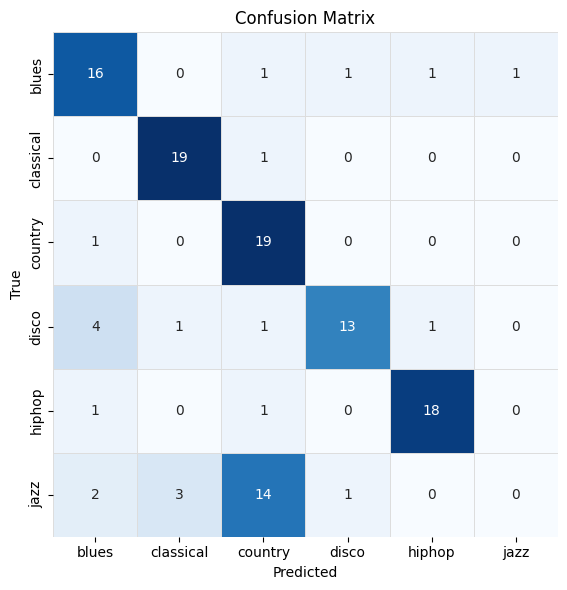

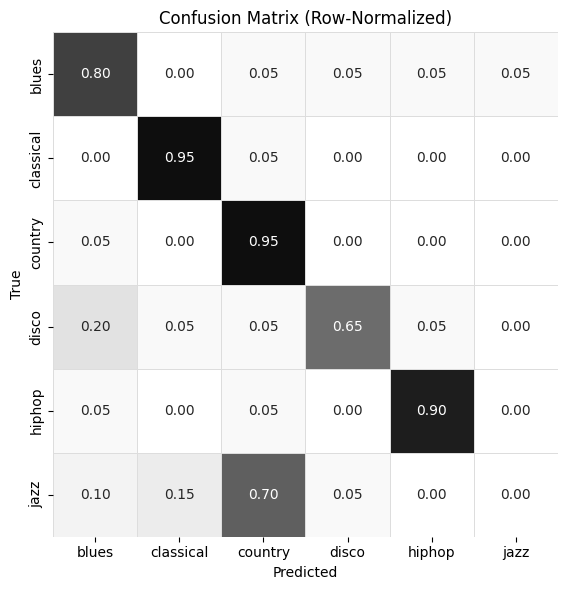

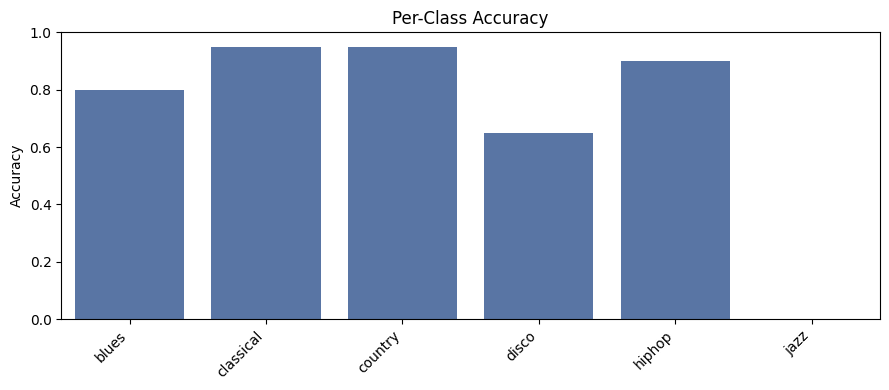

In [202]:
# Plots and save to docs/visuals directory
visuals_dir = 'docs/visuals'
os.makedirs(visuals_dir, exist_ok=True)

# Plot 1: Raw confusion Matrix
# each row sums to 20 (Jazz is being misclassified as country )
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes_to_keep, yticklabels=classes_to_keep,
            linewidths=0.5, linecolor='#ddd', square=True,
            annot_kws={'fontsize':10})
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("docs/visuals/confusion_matrix.png", dpi=200, bbox_inches='tight')

# Plot 2: Normalzed confusion matrix 
# each row sums to 1 (darker = more accurate)
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greys', cbar=False,
            vmin=0, vmax=1,
            xticklabels=classes_to_keep, yticklabels=classes_to_keep,
            linewidths=0.5, linecolor='#ddd', square=True,
            annot_kws={'fontsize':10})
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix (Row-Normalized)')
plt.tight_layout() 
plt.savefig("docs/visuals/confusion_matrix_norm.png", dpi=200, bbox_inches='tight')
per_class_acc = np.diag(cm_norm)

# Plot 3: Per-class accuracy bar chart
plt.figure(figsize=(9,4))
sns.barplot(x=classes_to_keep, y=per_class_acc, color='#4C72B0')
plt.ylim(0,1); plt.ylabel('Accuracy'); plt.title('Per-Class Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.savefig("docs/visuals/per_class_accuracy.png", dpi=200, bbox_inches='tight')
